In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import zipfile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import cv2

In [22]:
#!git clone https://github.com/Mvryo02/Plane-anomaly-detection-.git

Cloning into 'Plane-anomaly-detection-'...
fatal: unable to access 'https://github.com/Mvryo02/Plane-anomaly-detection-.git/': Could not resolve host: github.com


In [ ]:
#calcolare mean e standard deviation da sostituire in transform.Normalize di train
temporal_transform = transforms.Compose([
    transforms.ToTensor()
])

os.chdir("/content/Plane-anomaly-detection-/")

dataset = datasets.ImageFolder(root='./train', transform=temporal_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
nb_samples = 0

for data in dataloader:
    imgs, _ = data
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

In [5]:
def bilateral_filter(image):
    np_image = np.array(image)  # Convert PIL image to numpy array
    filtered = cv2.bilateralFilter(np_image, d=9, sigmaColor=75, sigmaSpace=75)
    return Image.fromarray(filtered)  # Convert back to PIL image

def sharpen(image):
    np_image = np.array(image)  # Convert PIL image to numpy array
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(np_image, -1, kernel)
    return Image.fromarray(sharpened)  # Convert back to PIL image

class CustomTransform:
    def __init__(self, additional_transform=None):
        self.additional_transform = additional_transform

    def __call__(self, img):
        img = bilateral_filter(img)  # Applicare il filtro bilaterale
        img = sharpen(img)  # Applicare il filtro di sharpening
        if self.additional_transform:
            img = self.additional_transform(img)
        return img

transform_train = transforms.Compose([
    CustomTransform(),                                                              # Applicare filtri personalizzati
    transforms.RandomHorizontalFlip(p=0.5),                                         # Flip orizzontale casuale per data augmentation
    transforms.RandomRotation(15),                                                  # Rotazione casuale di 15 gradi per data augmentation
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),                           # Modifica casuale dei colori per data augmentation
    transforms.Resize((800,800)),                                                    # Ridimensiona l'immagine a 800x800
    transforms.ToTensor(),                                                              # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.4743, 0.5177, 0.5279], std=[0.1772, 0.1736, 0.1722]),  # Normalizza l'immagine con dati trovati
])

transform_test = transforms.Compose([
    CustomTransform(),  # Applicare filtri personalizzati
    transforms.Resize((800,800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 800x800 -> 400x400
            nn.ReLU(True),        # ReLU(True) activation function: modifica l'input originale per risparmiare memoria e leggermente più veloce.
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 400x400 -> 200x200
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 200x200 -> 100x100
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 100x100 -> 200x200 #output_padding: Aggiunge pixel extra all'output della convoluzione trasposta per raggiungere una dimensione spaziale specifica. Serve per garantire che l'output abbia esattamente la dimensione desiderata, correggendo eventuali discrepanze che potrebbero derivare dall'uso di stride e padding.
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 200x200 -> 400x400
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # 400x400 -> 800x800
            nn.Sigmoid()   # Per mappare l'output nello stesso range [0, 1] delle immagini in input
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Numero di immagini per il train nel dataset: 1639
Numero di immagini per il test nel dataset: 521


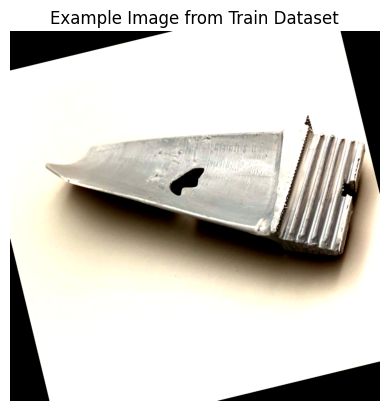

In [10]:
#os.chdir("/content/Plane-anomaly-detection-/")

train = datasets.ImageFolder(root='/kaggle/input/aebadcomplete/AeBADkaggle/test', transform=transform_train)
trainloader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
num_elements = len(train)
print(f"Numero di immagini per il train nel dataset: {num_elements}")

test = datasets.ImageFolder(root='/kaggle/input/aebadcomplete/AeBADkaggle/train', transform=transform_test)
testloader = DataLoader(test, batch_size=32, shuffle=True, pin_memory=True)
num_elements = len(test)
print(f"Numero di immagini per il test nel dataset: {num_elements}")

#test per vedere se immagini sono tensori e visualizzare immagini
def imshow(tensor_image, title=None):
    # Converti il tensore in un array NumPy
    image = tensor_image.numpy()

    # Normalizza l'immagine se necessario (assumiamo che il range sia [-1, 1] o [0, 1])
    if image.min() < 0:  # Normalizzazione [-1, 1] -> [0, 1]
        image = (image + 1) / 2
    image = np.clip(image, 0, 1)  # Assicurati che i valori siano tra 0 e 1

    # Se l'immagine è in formato CHW (Channel, Height, Width), convertila in HWC (Height, Width, Channel)
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    # Visualizza l'immagine
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

data_iter = iter(trainloader)
images, _ = next(data_iter)  # Ottieni un batch di immagini e target

# Seleziona la prima immagine del batch
image = images[0]

# Visualizza l'immagine
imshow(image, title='Example Image from Train Dataset')

In [ ]:
k_folds = 2 #numero di fold, metto 10 dato che dataset non è molto grande
kf = KFold(n_splits=k_folds, shuffle=True)

# Assicurati che il dispositivo sia impostato su GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Verifica se la GPU è disponibile
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

# Funzione di training e valutazione
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()       #modello impostato in modalita train, abilitato dropout e batch normalization

        # Aggiungi questa stampa per ogni epoca per verificare il dispositivo in uso
        print(f"Device in use: {next(model.parameters()).device}")

        running_loss = 0.0
        for images, _ in train_loader:  #per ogni batch di immagini in train_loader
            images = images.to('cuda')  # Trasferire i dati sulla GPU
            optimizer.zero_grad()       #Azzeramento dei gradienti per evitare l'accumulo
            outputs = model(images)     #forward pass
            loss = criterion(outputs, images) #Calcolo della perdita confrontando l'output del modello con l'input originale (in un autoencoder).
            loss.backward()           #Calcolo del gradiente rispetto ai parametri.
            optimizer.step()          #Aggiornamento dei parametri del modello basato sul gradiente calcolato
            running_loss += loss.item()

        model.eval()  #modello  impostato in modalità eval(), disabilitato dropout e batch normalization
        val_loss = 0.0
        with torch.no_grad(): #Non vengono calcolati i gradienti per rendere piu efficiente
            for images, _ in val_loader:
                images = images.to('cuda')  # Trasferire i dati sulla GPU
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()   #Si calcola la val_loss (perdita sul set di validazione) per ogni batch di immagini nel val_loader

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')  #Al termine di ogni epoca, si stampa la perdita media sia per il set di addestramento (running_loss) che per il set di validazione (val_loss)


In [ ]:
# Itera su ciascun fold
results = []  #Questa lista verrà utilizzata per memorizzare la perdita media di validazione per ciascun fold. Alla fine del processo, conterrà la perdita per ogni fold.

for fold, (train_ids, val_ids) in enumerate(kf.split(train)):
    print(f'Fold {fold+1}/{k_folds}') #fold è il fold i-esimo che va da 0 a k-fold-1

    # Crea i sotto-dataset per il training e la validazione
    train_subsampler = Subset(train, train_ids) #Subset: Crea un sotto-dataset usando gli indici forniti.
    val_subsampler = Subset(train, val_ids) #train_subsampler contiene i dati per il training, mentre val_subsampler contiene i dati per la validazione

    # Crea i dataloader per il training e la validazione
    train_loader = DataLoader(train_subsampler, batch_size=32, shuffle=True)  #Questo insieme di dati è una porzione del dataset totale, ottenuta escludendo il fold corrente che viene usato per la validazione.
    val_loader = DataLoader(val_subsampler, batch_size=32, shuffle=False)     #Questa è la porzione di dati che viene esclusa dall'addestramento per essere utilizzata come set di validazione in quel fold

    # Inizializza il modello, la loss function e l'optimizer
    model = ConvAutoencoder().cuda()  # Trasferire il modello sulla GPU
    criterion = nn.MSELoss()  # La funzione di perdita è la Mean Squared Error (MSE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Viene usato l'algoritmo Adam per ottimizzare i parametri del modello, con un learning rate di 0.001

    # Allena e valuta
    train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=7) #chiamata a funzione che valuta modello sopra definita

    # Valutazione finale su questo fold
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to('cuda')  # Trasferire i dati sulla GPU
            outputs = model(images) #: Calcola l'output del modello dato un batch di immagini.
            loss = criterion(outputs, images) #Calcola la perdita tra l'output del modello e l'input originale (essendo autoencoder)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader) #Calcola la perdita media di validazione per questo fold
    results.append(avg_val_loss)  # Aggiunge la perdita media di validazione alla lista results.
    print(f'Fold {fold+1} Validation Loss: {avg_val_loss}')

# Risultati finali
print(f'K-Fold Cross Validation results: {results}')  #Mostra la perdita di validazione media per ciascun fold
print(f'Average Validation Loss: {np.mean(results)}') #Calcola la media delle perdite di validazione su tutti i fold, fornendo una stima complessiva delle prestazioni del modello.

In [ ]:
#deinizione funzione per vedere immagine e ricostruzione effettuata da autoencoder

def visualize_reconstruction(model, test_loader, num_images=5):
    model.eval()
    images, _ = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(images)

    outputs = torch.clamp(outputs, 0, 1) # Questo passaggio garantisce che tutti i valori dei pixel siano compresi tra 0 e 1, evitando così il problema (warning) con la visualizzazione.
    images = torch.clamp(images, 0, 1)

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy()) #Permuta le dimensioni dell'immagine da (C, H, W) a (H, W, C) per renderle compatibili con matplotlib, che si aspetta che i dati di immagine siano nel formato (altezza, larghezza, canali).
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis('off')

    plt.show()

# Visualizza le ricostruzioni
visualize_reconstruction(model, testloader)

In [ ]:
#definizione della funzione per valutare modello sul test set
def test_model(model, test_loader, criterion):
    model.eval() #imposta il modello in modalità di valutazione. Questo è importante perché disabilita comportamenti specifici del training come il dropout o la batch normalization, che sono attivi solo durante l'addestramento.
    test_loss = 0.0 #Questa variabile accumulerà la perdita su tutti i batch di test.
    with torch.no_grad():
        for images, _ in test_loader: # Il ciclo for itera su tutti i batch del test_loader, images: Contiene un batch di immagini del set di test.
            outputs = model(images) #Il modello prende come input le immagini e restituisce l'output ovvero una ricostruzione dell'immagine.
            loss = criterion(outputs, images) #La loss viene calcolata confrontando l'output del modello con l'immagine originale
            test_loss += loss.item()  #Il valore della loss viene sommato a test_loss per accumulare la perdita totale su tutti i batch.

    avg_test_loss = test_loss / len(test_loader)  #La perdita media viene calcolata dividendo la perdita totale accumulata (test_loss) per il numero di batch (len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')
    return avg_test_loss  #Questa metrica rappresenta la media delle perdite calcolate per ciascun esempio nel test set


#chiamata a funzione di valutazione modello su test
final_test_loss = test_model(model, testloader, criterion)  #Questo esegue la funzione test_model e assegna la avg_test_loss calcolata alla variabile final_test_loss

In [ ]:
# Funzione per calcolare l'errore di ricostruzione (MSE) e SSIM tra immagine originale e ricostruita
#MSE (Mean Squared Error): Misura la differenza quadratica media tra i valori dei pixel delle immagini originale e ricostruita.
#SSIM (Structural Similarity Index): È una metrica che misura la similarità tra due immagini, tenendo conto della luminanza, contrasto e struttura.

def calculate_errors(original, reconstructed):
    mse = F.mse_loss(reconstructed, original).item()  #calcolo del mse
    print("Original size:", original.shape)
    print("Reconstructed size:", reconstructed.shape)
    ssim_index = ssim(original.cpu().numpy().transpose(1, 2, 0), reconstructed.cpu().numpy().transpose(1, 2, 0), multichannel=True, win_size=3, data_range=1.0) #calcolo del ssim
    return mse, ssim_index

# Funzione per visualizzare e identificare le immagini ben riconosciute e quelle meno
def evaluate_model_performance(model, test_loader, threshold_mse=0.01, threshold_ssim=0.7, num_images=10):
    model.eval()
    detected_anomalies = 0
    for i, (images, _) in enumerate(test_loader):
        if i >= num_images:
            break

        with torch.no_grad():
            outputs = model(images)

        for j in range(images.size(0)):
            original = images[j]
            reconstructed = outputs[j]

            # Calcola l'errore di ricostruzione e SSIM
            mse, ssim_index = calculate_errors(original, reconstructed)

            # Stampa i valori di MSE e SSIM
            print(f"Image {j+1} in batch {i+1}: MSE = {mse:.4f}, SSIM = {ssim_index:.4f}")

            # Visualizza le immagini originali e ricostruite
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            ax[0].imshow(original.cpu().numpy().transpose(1, 2, 0))
            ax[0].set_title('Original')
            ax[0].axis('off')

            ax[1].imshow(reconstructed.cpu().numpy().transpose(1, 2, 0))
            ax[1].set_title(f'Reconstructed\nMSE: {mse:.4f}, SSIM: {ssim_index:.4f}')
            ax[1].axis('off')

            plt.show()

            # Verifica se l'errore supera la soglia e stampa un avviso
            if mse > threshold_mse or ssim_index < threshold_ssim:
                print(f'Anomaly Detected: Image {j+1} in batch {i+1}')
                detected_anomalies += 1

    print(f"Total anomalies detected: {detected_anomalies}")

# Esegui la valutazione
evaluate_model_performance(model, testloader, threshold_mse=0.01, threshold_ssim=0.7, num_images=10)